In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gwpopulation as gwpop # using the mass model there

In [2]:
def infer_required_args_from_function_except_n_args(func, n=1): # Modified from bilby, to get the arguments of posterior
    fullparameters = inspect.getfullargspec(func)
    parameters = fullparameters.args[:len(fullparameters.args) - len(fullparameters.defaults)]
    del parameters[:n]
    return parameters

In [3]:
p_m1 = gwpop.models.mass.two_component_primary_mass_ratio

def compute_log_likelihood_per_event(data, Lambda, prior):
    return np.mean(p_m1(data, *Lambda)/prior)

def log_likelihood(Lambda, posteriors):
    log_likelihood = 0.
    for posterior in posteriors:
        if "prior" in posterior:
            prior = posterior.pop("prior")
        else:
            prior = 1
        log_likelihood += compute_log_likelihood_per_event(posterior, Lambda, prior)
    return log_likelihood

In [4]:
import h5py
import pandas as pd
from scipy.interpolate import interp1d
from astropy import cosmology, units

In [5]:
parameter_translator = dict(
    mass_1_det="m1_detector_frame_Msun",
    mass_2_det="m2_detector_frame_Msun",
    luminosity_distance="luminosity_distance_Mpc",
    a_1="spin1",
    a_2="spin2",
    cos_tilt_1="costilt1",
    cos_tilt_2="costilt2",
)

posteriors = list()
priors = list()

file_str = "./GWTC-1_sample_release/GW{}_GWTC-1.hdf5"

events = [
    "150914",
    "151012",
    "151226",
    "170104",
    "170608",
    "170729",
    "170809",
    "170814",
    "170818",
    "170823",
]
for event in events:
    _posterior = pd.DataFrame()
    _prior = pd.DataFrame()
    with h5py.File(file_str.format(event)) as ff:
        for my_key, gwtc_key in parameter_translator.items():
            _posterior[my_key] = ff["IMRPhenomPv2_posterior"][gwtc_key]
            _prior[my_key] = ff["prior"][gwtc_key]
    posteriors.append(_posterior)
    priors.append(_prior)

In [6]:
luminosity_distances = np.linspace(1, 10000, 1000)
redshifts = np.array(
    [
        cosmology.z_at_value(cosmology.Planck15.luminosity_distance, dl * units.Mpc)
        for dl in luminosity_distances
    ]
)
dl_to_z = interp1d(luminosity_distances, redshifts)

luminosity_prior = luminosity_distances**2

dz_ddl = np.gradient(redshifts, luminosity_distances)

redshift_prior = interp1d(redshifts, luminosity_prior / dz_ddl / (1 + redshifts))

In [7]:
for posterior in posteriors:
    posterior["redshift"] = dl_to_z(posterior["luminosity_distance"])
    posterior["mass_1"] = posterior["mass_1_det"] / (1 + posterior["redshift"])
    posterior["mass_2"] = posterior["mass_2_det"] / (1 + posterior["redshift"])
    posterior["mass_ratio"] = posterior["mass_2"] / posterior["mass_1"]

In [8]:
import bilby as bb
from bilby.core.prior import LogUniform, PriorDict, Uniform
from bilby.hyper.model import Model

In [9]:
fast_priors = PriorDict()

# mass
fast_priors["alpha"] = Uniform(minimum=-2, maximum=4, latex_label="$\\alpha$")
fast_priors["beta"] = Uniform(minimum=-4, maximum=12, latex_label="$\\beta$")
fast_priors["mmin"] = Uniform(minimum=5, maximum=10, latex_label="$m_{\\min}$")
fast_priors["mmax"] = Uniform(minimum=20, maximum=60, latex_label="$m_{\\max}$")
fast_priors["lam"] = Uniform(minimum=0, maximum=1, latex_label="$\\lambda_{m}$")
fast_priors["mpp"] = Uniform(minimum=10, maximum=50, latex_label="$\\mu_{m}$")
fast_priors["sigpp"] = Uniform(minimum=0, maximum=10, latex_label="$\\sigma_{m}$")

In [10]:
def log_prior(Lambda):
    alpha, beta, mmin, mmax, lam, mpp, sigpp = Lambda
    if -2<alpha<4 and -4<beta<12 and 5<mmin<10 and 20<mmax<60 and 0<lam<1 and 10<mpp<50 and 0<sigpp<10:
        return 0.
    return -np.inf

def log_probability(Lambda, *posteriors):
    lp = log_prior(Lambda)
    if not np.isfinite(lp):
        return -np.inf
    return log_likelihood(Lambda, posteriors) + lp

In [11]:
!pip install emcee

Defaulting to user installation because normal site-packages is not writeable


In [12]:
pos = list()
for param in list(fast_priors.keys()):
    pos.append(np.random.uniform(fast_priors[param].minimum<0, high=fast_priors[param].maximum, size=30))
pos = np.array(pos).transpose()


In [13]:
pos.shape

(30, 7)

In [14]:
import emcee

# pos = np.random.randint(0, high=50, size=(200, 7))

nwalkers, ndim = pos.shape

# pos = np.array(nwalkers)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(posteriors)
)
sampler.run_mcmc(pos, 1000, progress=True);

  0%|          | 0/1000 [00:00<?, ?it/s]/home/manchun.yeung/.local/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [22:41<00:00,  1.36s/it]


In [17]:
flat_samples = sampler.get_chain(discard=100, thin=100, flat=True)

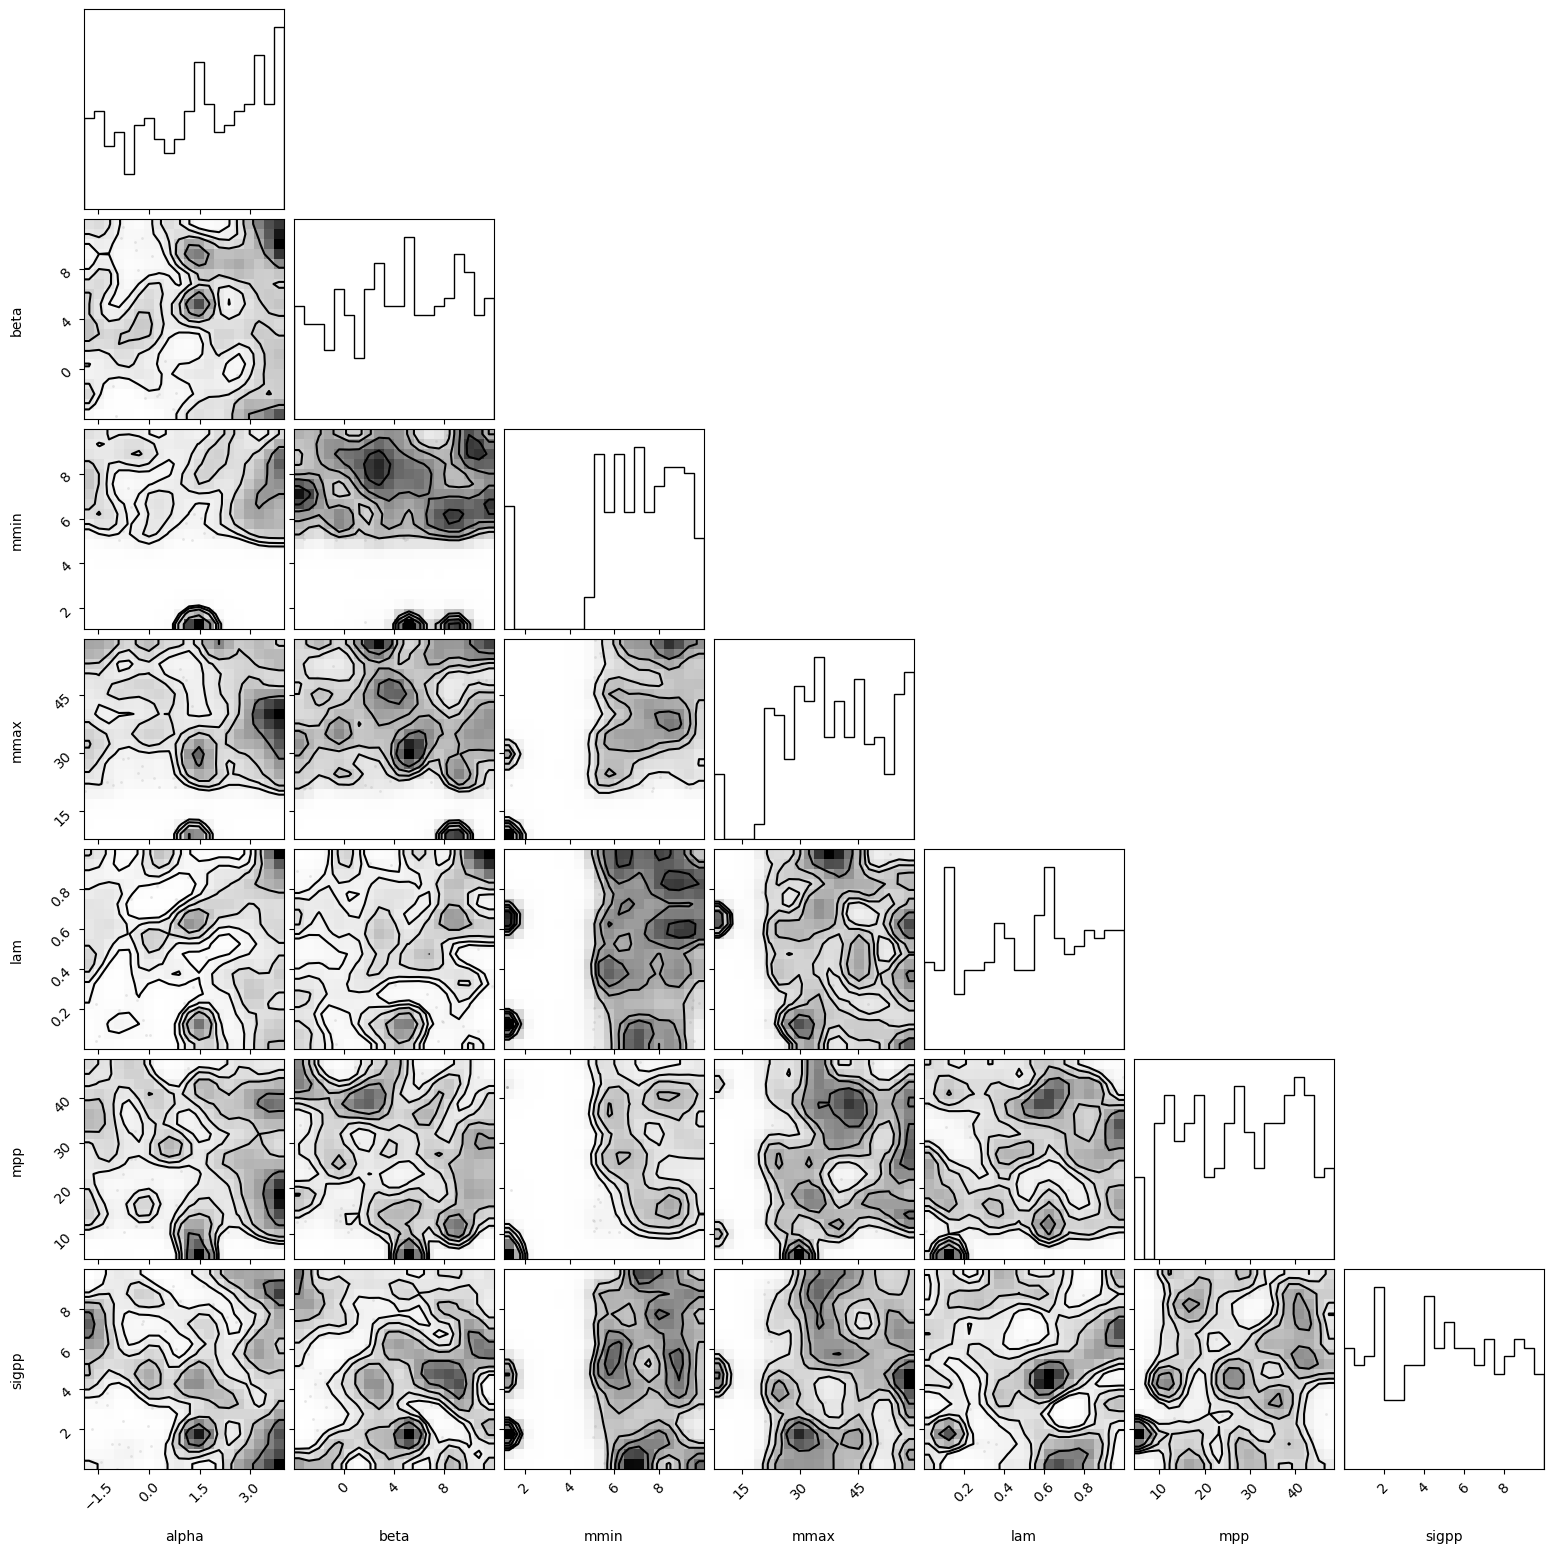

In [18]:
import corner

labels = ['alpha', 'beta', 'mmin', 'mmax', 'lam', 'mpp', 'sigpp']

fig = corner.corner(
    flat_samples, labels=labels, smooth=1.2
);